# Next Action Probabilities

In this notebook we show how ELECTRO/ELECTRO-LITE can be used to make predictions. We then go on to show how we can break down each step of the electron path and look at the probabilities the model assigned to each action (and their alternatives).



## Molecule Drawing Code 

Here we just define some functions that can be used for plotting molecules using rdkit and matplotlib.

In [1]:
# Misc module imports

import typing
import itertools

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.six import iteritems

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.patches as patches


In [2]:
# Molecule drawing plot

def new_init(self, size, name='', imageType='png', fig=None, ax=None):
    self._name = name
    self.size = size
    dpi = max(size[0], size[1])
    figsize = (int(float(size[0]) / dpi), int(float(size[1]) / dpi))
    if fig is None or ax is None:
        print("Creating new axis")
        self._figure = figure(figsize=figsize)
        self._axes = self._figure.add_axes([0, 0, 2.5, 2.5])
    else:
        self._figure = fig
        self._axes = ax
    self._axes.set_xticklabels('')
    self._axes.set_yticklabels('')
    self._dpi = dpi

from rdkit.Chem.Draw.mplCanvas import Canvas
Canvas.__init__ = new_init

    
def MolToMPL(mol, size=(300, 300), kekulize=True, wedgeBonds=True, imageType=None, fitImage=False,
             options=None, fig=None, ax=None, **kwargs):
    """
    Generates a drawing of a molecule on a matplotlib canvas

    Small modification of the version in rdkit main so that it returns the drawer and mol after.
    
    The rdkit version can be found @:
    https://github.com/rdkit/rdkit/blob/00cb303096c9a35ae5c76275914972382c2f39c1/rdkit/Chem/Draw/__init__.py
    
    Rdkit licence is:
    Unless otherwise noted, all files in this directory and all
    subdirectories are distributed under the following license:

    Copyright (c) 2006-2015
    Rational Discovery LLC, Greg Landrum, and Julie Penzotti 

    All rights reserved.

    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are
    met: 

        * Redistributions of source code must retain the above copyright 
          notice, this list of conditions and the following disclaimer.
        * Redistributions in binary form must reproduce the above
          copyright notice, this list of conditions and the following 
          disclaimer in the documentation and/or other materials provided 
          with the distribution.
        * Neither the name of Rational Discovery nor the names of its 
          contributors may be used to endorse or promote products derived 
          from this software without specific prior written permission.

    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
    "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
    LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
    A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
    OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
    SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
    LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
    DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
    THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
    (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
    OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE
    
    """
    if not mol:
        raise ValueError('Null molecule provided')
    from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
    
    
    
    canvas = Canvas(size, fig=fig, ax=ax)

    
    if options is None:
        options = DrawingOptions()
        options.bgColor = None
    if fitImage:
        options.dotsPerAngstrom = int(min(size) / 10)
    options.wedgeDashedBonds = wedgeBonds
    options.atomLabelFontSize = 8
    drawer = MolDrawing(canvas=canvas, drawingOptions=options)
    omol = mol
    if kekulize:
        from rdkit import Chem
        mol = Chem.Mol(mol.ToBinary())
        Chem.Kekulize(mol)

    if not mol.GetNumConformers():
        from rdkit.Chem import AllChem
        AllChem.Compute2DCoords(mol)

    drawer.AddMol(mol, **kwargs)
    omol._atomPs = drawer.atomPs[mol]
    for k, v in iteritems(omol._atomPs):
        omol._atomPs[k] = canvas.rescalePt(v)
    return canvas._figure, drawer, mol

## Predictions

We now show how we can use ELECTRO-LITE to predict the final molecules.

In [3]:
# More misc module imports 

import torch

from rdkit import Chem
from matplotlib import pyplot as plt

from graph_neural_networks.core import utils

from rxn_steps.model import get_electro
from rxn_steps.predict import beam_searcher



In [4]:
# In this cell we load in the model, weights and beam search code.

cuda_details = utils.CudaDetails(use_cuda=False)

# Model
variant = get_electro.ElectroVariants.ELECTRO_LITE
full_model = get_electro.get_model(variant, cuda_details=cuda_details)
full_model = cuda_details.return_cudafied(full_model)

# Weights!
checkpoint = torch.load('../scripts/train_electro/chkpts/electrolite.pth.pick', map_location='cpu')
full_model.load_state_dict(checkpoint['state_dict'])

# Beam searcher
predictor = beam_searcher.PredictiveRanking(full_model, cuda_details)

# Get the dataset
from rxn_steps.data import lef_uspto
from rxn_steps.data import transforms as r_trsfms

tsfms = r_trsfms.TransformStrToBrokenDownParts()

dataset = lef_uspto.LEFUspto(variant=lef_uspto.DataVariants.VAL, transform=tsfms)


Reading file: /Users/jbradshaw/scratch/uni_projects/rxn-steps/lef_uspto/filtered_valid.txt


In [5]:
# We now create a function to plot the predictions.

def clear_atom_map(mol):
    for atom in mol.GetAtoms():
        atom.ClearProp('molAtomMapNumber')

def top_k_predictions(reactants, reagents='', top_k=1):
    fig, axarr = plt.subplots(1, top_k+1, figsize=(7*top_k, 6), dpi=300)

    predicted_result = predictor.predict_out(reactants, reagents)
    
    # Plot reactants
    reactants = Chem.MolFromSmiles(reactants)
    clear_atom_map(reactants)
    MolToMPL(reactants, fig=fig, ax=axarr[0])
    axarr[0].set_title('Reactants')
    
    for k in range(top_k):
        act_seq = predicted_result[k]

        product_mol = act_seq.get_intermediate_molecule(len(act_seq))
        log_prob = act_seq.total_prob
        clear_atom_map(product_mol)

        MolToMPL(product_mol, fig=fig, ax=axarr[k+1])
        axarr[k+1].set_title(f'Product choice {k} (prob: {np.exp(log_prob):.3f})')


Having set up this code we can now look at the predictions given a string of atom mapped reactants. 
We will just use the first item of the validation dataset as an example.
First of all we shall find out the reactant string:

In [6]:
dataset[0]

BrokenDownParts(reactants='[NH2:1][c:2]1[n:3][c:4]([Cl:18])[c:5]([C:16]#[N:17])[c:6](-[c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[c:7]1[C:8]#[N:9].[OH:25][CH2:26][c:27]1[n:28][cH:29][cH:30][cH:31][cH:32]1', reagents='[CH3:19][C:20]([CH3:21])([O-:22])[CH3:23].[K+:24]', products='[NH2:1][c:2]1[n:3][c:4]([O:25][CH2:26][c:27]2[n:28][cH:29][cH:30][cH:31][cH:32]2)[c:5]([C:16]#[N:17])[c:6](-[c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[c:7]1[C:8]#[N:9]', ordered_am_path=[25, 25, 4, 18])

The ground truth reaction from the dataset looks like:




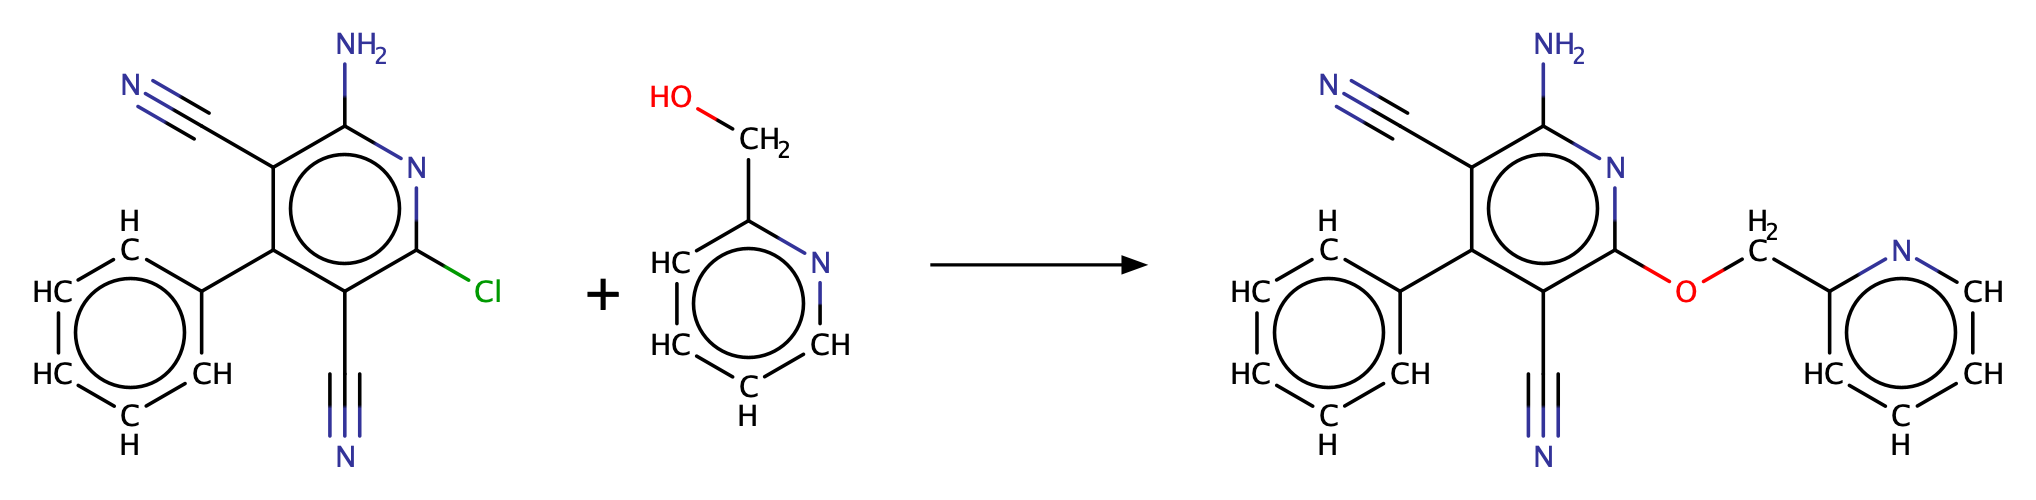

In [7]:
from IPython.display import Image
Image(filename='../imgs/valid_reaction1_no_reagents.png',width=1000, height=800)  # (nb not plotting reagents)


Next we shall see what ELECTRO-LITE predicts out as products:

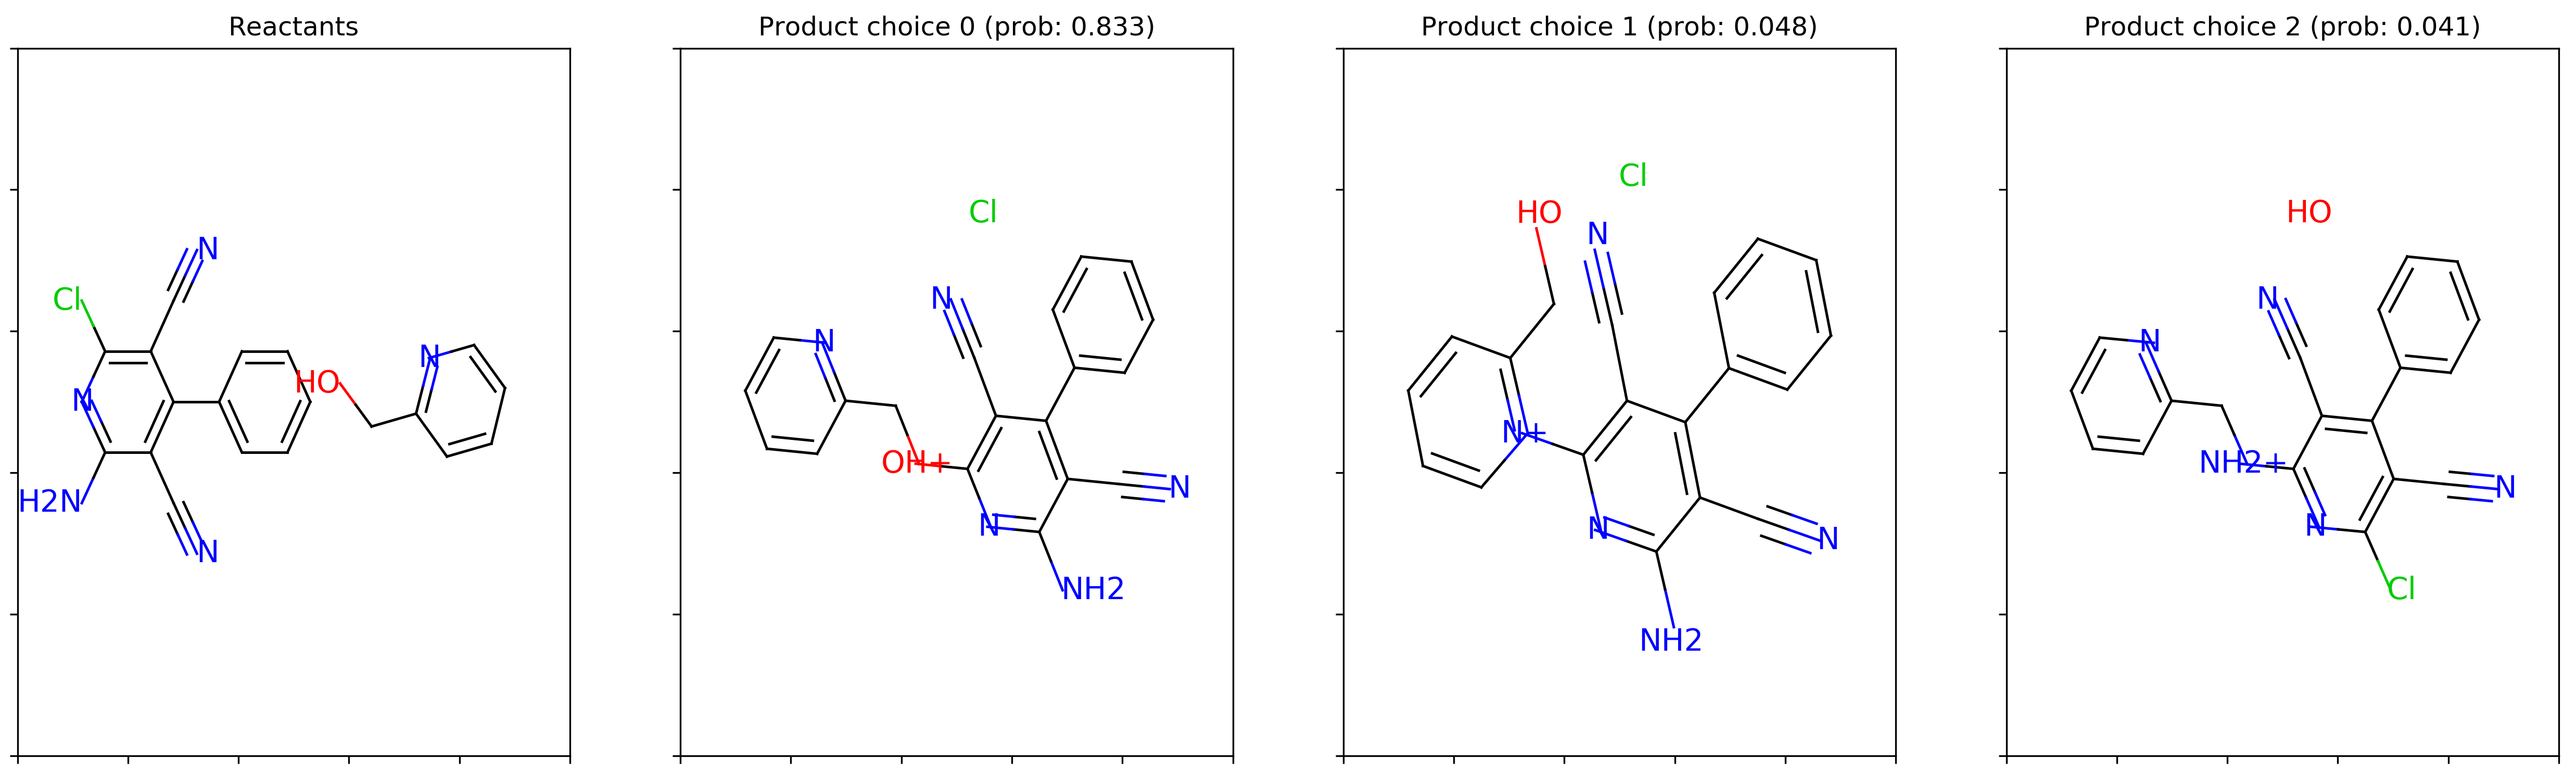

In [8]:
top_k_predictions('[NH2:1][c:2]1[n:3][c:4]([Cl:18])[c:5]([C:16]#[N:17])[c:6](-[c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[c:7]1[C:8]#[N:9].[OH:25][CH2:26][c:27]1[n:28][cH:29][cH:30][cH:31][cH:32]1',
                 top_k=3)

Note that we do not add a negative charge to the atoms at the end of this path (often Cl in this particular example) or deal with the fact that implicit Hydrogen bonds may also be broken as part of the reactions.

We haven't fully investigated the best way to do this but perhaps this task can be done by using the code of [Jin et al, 2017](http://papers.nips.cc/paper/6854-predicting-organic-reaction-outcomes-with-weisfeiler-lehman-network)
available at https://github.com/wengong-jin/nips17-rexgen/blob/master/USPTO/scripts/eval.py. We shall show how this can be done below.

In [9]:
# We first copy the relevant code

"""
This cell's code comes from https://github.com/wengong-jin/nips17-rexgen/blob/master/USPTO/scripts/eval.py

The associated licence is @ https://github.com/wengong-jin/nips17-rexgen/blob/master/LICENSE

MIT License

Copyright (c) 2017 Wengong Jin, Connor W. Coley, Regina Barzilay, Tommi Jaakkola and Klavs F. Jensen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
BOND_TYPE = [0, Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC] 


def copy_edit_mol(mol):
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = Chem.Atom(atom.GetSymbol())
        new_atom.SetFormalCharge(atom.GetFormalCharge())
        new_atom.SetAtomMapNum(atom.GetAtomMapNum())
        new_mol.AddAtom(new_atom)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
    return new_mol

def edit_mol(rmol, edits):
    new_mol = copy_edit_mol(rmol)
    amap = {}
    for atom in rmol.GetAtoms():
        amap[atom.GetIntProp('molAtomMapNumber')] = atom.GetIdx()

    for x,y,t in edits:
        bond = new_mol.GetBondBetweenAtoms(amap[x],amap[y])
        a1 = new_mol.GetAtomWithIdx(amap[x])
        a2 = new_mol.GetAtomWithIdx(amap[y])
        if bond is not None:
            new_mol.RemoveBond(amap[x],amap[y])
        if t > 0:
            new_mol.AddBond(amap[x],amap[y],BOND_TYPE[t])

    pred_mol = new_mol.GetMol()

    #Clear formal charges to make molecules valid
    for atom in pred_mol.GetAtoms():
        atom.ClearProp('molAtomMapNumber')
        if atom.GetSymbol() == 'N' and atom.GetFormalCharge() != 0:
            bond_vals = sum([bond.GetBondTypeAsDouble() for bond in atom.GetBonds()])
            if bond_vals <= 3:
                atom.SetFormalCharge(0)
        if atom.GetSymbol() == 'O' and atom.GetFormalCharge() != 0:
            bond_vals = sum([bond.GetBondTypeAsDouble() for bond in atom.GetBonds()])
            if bond_vals == 2:
                atom.SetFormalCharge(0)
        elif atom.GetSymbol() in ['Cl', 'I', 'P', 'C'] and atom.GetFormalCharge() != 0:
            atom.SetFormalCharge(0)

    pred_smiles = Chem.MolToSmiles(pred_mol)
    pred_list = pred_smiles.split('.')
    pred_mols = [Chem.MolFromSmiles(pred_smiles) for pred_smiles in pred_list]
    pred_smiles = [Chem.MolToSmiles(pred_mol) for pred_mol in pred_mols if pred_mol is not None]

    return pred_smiles





In [10]:
# We can now write a new function that turns our action path into graph edits.

from rxn_steps.data.rdkit_ops import chem_details
from rxn_steps.data.rdkit_ops import rdkit_general_ops


def action_to_bond_edits(reactants: Chem.Mol, actions_am: typing.List[int]):
    
    # 1. Work out what action starts
    # 1a we start with a self-bond remove, in terms of edits that
    # means the first bond gets larger (an add)
    if actions_am[0] == actions_am[1]:
        actions_am = actions_am[1:]
        previous = chem_details.ElectronMode.ADD 
    # 1b we start with a normal bond remove
    else:
        previous = chem_details.ElectronMode.REMOVE 

    # 2. Go through the actions and work out the new bonds as a result of following this path.
    edits = []
    for prev_, next_ in zip(actions_am[:-1], actions_am[1:]):
        prev_bond = rdkit_general_ops.get_bond_double_between_atom_mapped_atoms(
            reactants, prev_, next_)
        change = -1 if previous is chem_details.ElectronMode.REMOVE else 1
        new = int(prev_bond + change)
        edits.append((prev_, next_, new))
        previous = (chem_details.ElectronMode.REMOVE if 
                    previous is chem_details.ElectronMode.ADD else chem_details.ElectronMode.ADD)
        
    return edits


def top_k_predictions_via_bond_edits(reactants, reagents='', top_k=1):
    fig, axarr = plt.subplots(1, top_k+1, figsize=(7*top_k, 6), dpi=300)

    predicted_result = predictor.predict_out(reactants, reagents)
    
    # Get reactants
    reactants = Chem.MolFromSmiles(reactants)

    # Get predictions
    for k in range(top_k):
        act_seq = predicted_result[k]

        actions = act_seq.actions_as_am 
        edits = action_to_bond_edits(act_seq.intermediates_mols[0], actions)
        product_smi = '.'.join(edit_mol(reactants, edits))
        product_mol = Chem.MolFromSmiles(product_smi)
        
        log_prob = act_seq.total_prob
        clear_atom_map(product_mol)

        MolToMPL(product_mol, fig=fig, ax=axarr[k+1])
        axarr[k+1].set_title(f'Product choice {k} (prob: {np.exp(log_prob):.3f})')
        
    # Plot Reactants (we do this after as we only want to clear atom mappings right at very end)
    clear_atom_map(reactants)
    MolToMPL(reactants, fig=fig, ax=axarr[0])
    axarr[0].set_title('Reactants')



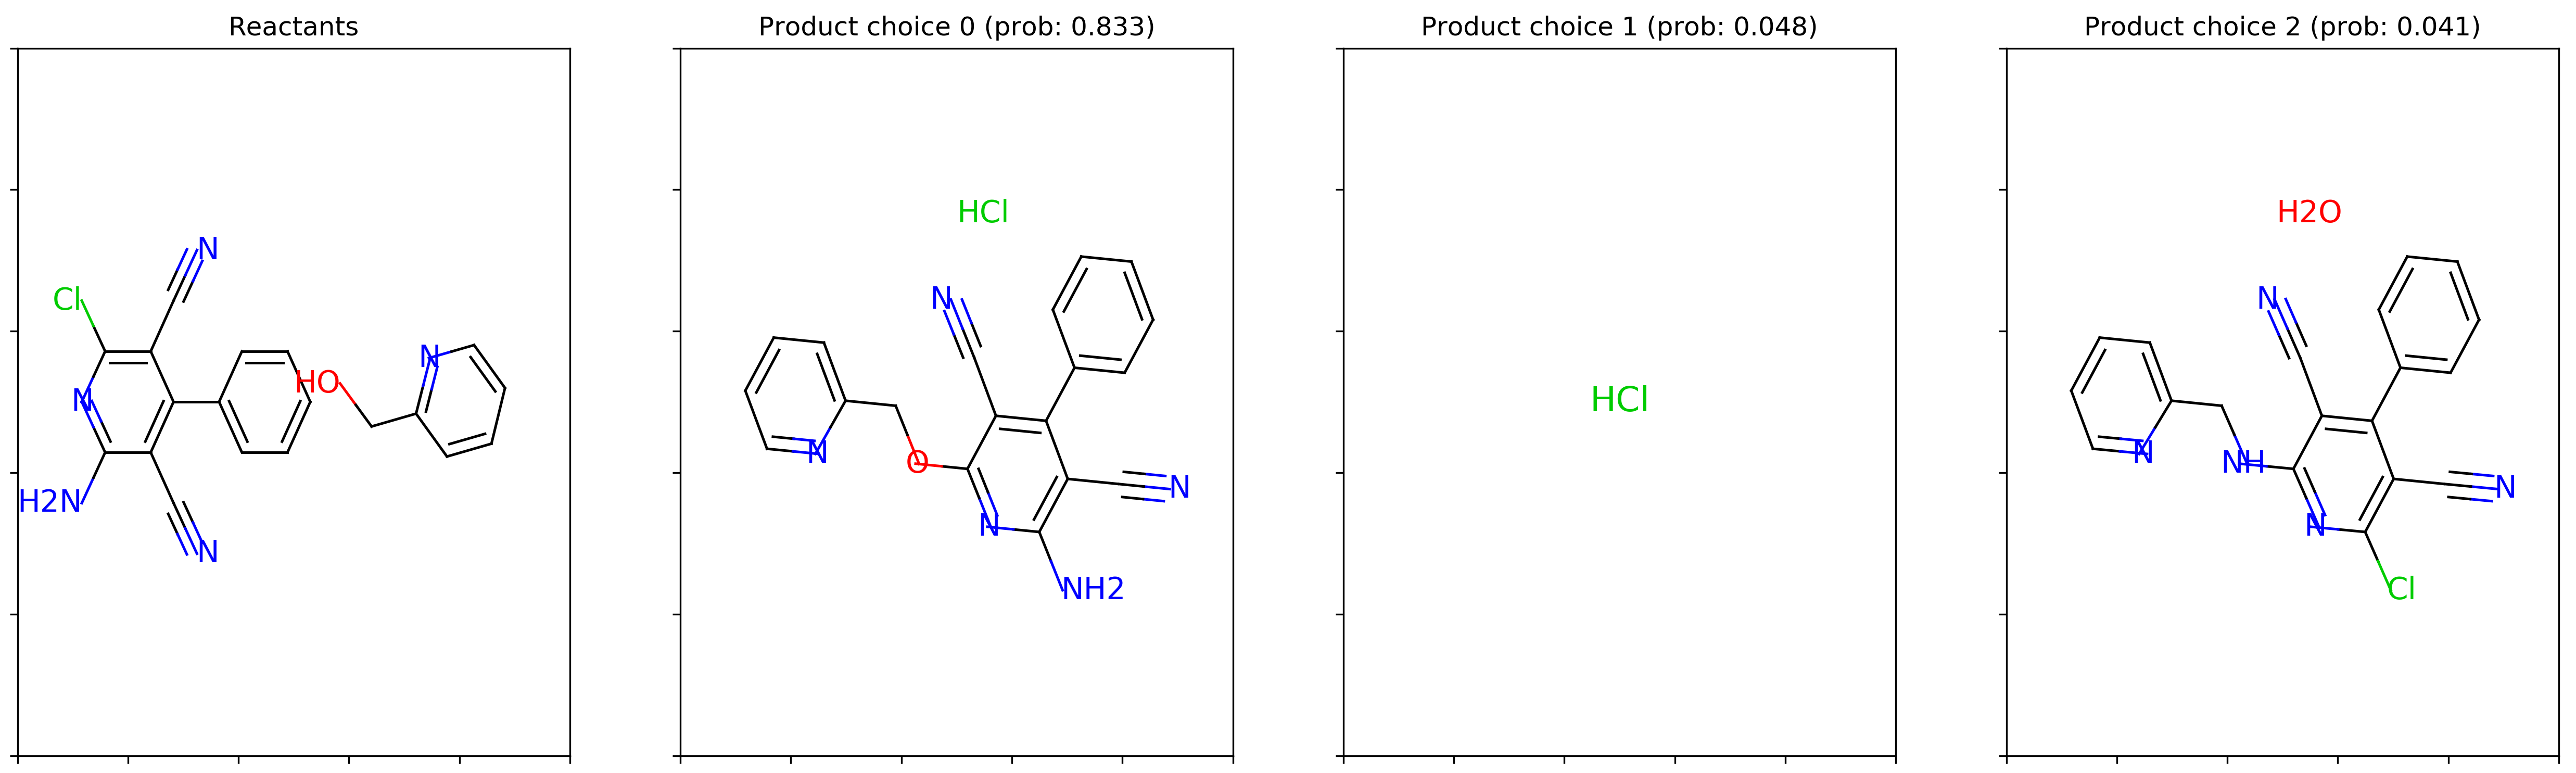

In [11]:
top_k_predictions_via_bond_edits('[NH2:1][c:2]1[n:3][c:4]([Cl:18])[c:5]([C:16]#[N:17])[c:6](-[c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[c:7]1[C:8]#[N:9].[OH:25][CH2:26][c:27]1[n:28][cH:29][cH:30][cH:31][cH:32]1',
                 top_k=3)

## Delving into Action Probabilities

Having shown how our model can be used to make final product predictions we now in this section look at the probabilites our model assigns to the different actions in each step. 

We shall first set up the code to do this below, before again looking at the first item of the validation dataset as a specific example.

In [12]:
# In this cell we shall do the plotting code


from rxn_steps.data.rdkit_ops import rdkit_general_ops

class CircleOutlineDetails(typing.NamedTuple):
    line_color: str
    line_edge_width: float
    line_style: str

class CircleInsideDetails(typing.NamedTuple):
    color: str
    opacity: float

class AtomCircler(object):
    def __init__(self, circle_outline: typing.Optional[CircleOutlineDetails]=None,
                 circle_inside: typing.Optional[CircleInsideDetails]=None):
        self.circle_outline = circle_outline
        self.circle_inside = circle_inside

    def get_kw_dict(self):
        kwargs = dict(
            edgecolor=None if self.circle_outline is None else self.circle_outline.line_color,
            facecolor=None if self.circle_inside is None else self.circle_inside.color,
            linewidth=None if self.circle_outline is None else self.circle_outline.line_edge_width,
            linestyle=None if self.circle_outline is None else self.circle_outline.line_style,
        )

        if self.circle_inside is not None:
            kwargs['alpha'] = self.circle_inside.opacity
        return kwargs

    
def draw_mol_with_highlights(molecule_in, 
                            circles_to_draw: typing.Mapping[int, AtomCircler],
                            xs_to_draw: typing.List[int],
                            fig=None, ax=None, **kwargs):
    # We draw the molecule!
    fig, drawer, mol = MolToMPL(molecule_in, fig=fig, ax=ax, **kwargs)
    ax = fig.axes[0] if ax is None else ax

    # We compute the necessary mappings for going from atom map number to position
    atom_mapping_to_idx = {atom.GetPropsAsDict()['molAtomMapNumber']: idx for idx,
                           atom in enumerate(molecule_in.GetAtoms())}
    mol_locations = drawer.atomPs[mol]

    # we look at the bond size to work out an appropriate size for the circles
    bond0 = mol.GetBonds()[0]
    begin = bond0.GetBeginAtom()
    end = bond0.GetEndAtom()
    bond_dist = np.sqrt(np.sum((np.array(mol_locations[begin.GetIdx()]) 
                                - np.array(mol_locations[end.GetIdx()]))**2))

    # We now go through and add the circles
    from matplotlib import patches
    for atom_am, patch_details in circles_to_draw.items():
        atom_idx = atom_mapping_to_idx[atom_am]
        atom_loc = mol_locations[atom_idx]
        patch = patches.Circle(atom_loc, radius=bond_dist / 4., **patch_details.get_kw_dict())
        ax.add_patch(patch)
    
    # add the crosses
    x_locs = []
    for am in xs_to_draw:
        atom_idx = atom_mapping_to_idx[am]
        atom_loc = mol_locations[atom_idx]
        x_locs.append(atom_loc)
    if len(x_locs):
        x_locs = np.array(x_locs)
        ax.plot(x_locs[:, 0], x_locs[:, 1], 'X', color='red', markersize=25, alpha=0.65)
    return fig, ax


def plot_actions(molecule: Chem.Mol, am_to_prob_dict: typing.Mapping[int, int],
                 disallowed_actions,
                 prev_mol_am: int=None, selected_am: int=None):
    """
    :param prev_mol_am: atom map number of the previously selected atom. None if first atom.
    :param selected_am: atom map number of atom that gets selected (note dure to beam search
    it may not be the atom with the highest probability.)
    """
    # we first set up a colormap for the probabilities as well as the plots and atom positions
    from matplotlib import cm
    from matplotlib import colorbar
    from  matplotlib import colors
    cmap = cm.get_cmap('Blues')
    norm_obj = colors.Normalize(vmin=0., vmax=1., clip=False)
    scalar_to_color = cm.ScalarMappable(norm_obj, cmap)
    fig, ax = plt.subplots(2, 1, figsize=(15, 9), gridspec_kw = {'height_ratios':[6, 1]})
    AllChem.Compute2DCoords(molecule)

    # Go through and add a color probabilitiy circle
    # over each atom with its respective proabbility
    atom_circlers = {}
    for k, v in am_to_prob_dict.items():
        atom_circlers[k] = AtomCircler(
                    circle_inside=CircleInsideDetails(
                           scalar_to_color.to_rgba(v), 1.0)
        )
        
        # if it was the previous atom or the one being selected we also add a circular outline
        prev_flag = prev_mol_am is not None and prev_mol_am == k
        select_flag = selected_am is not None and selected_am == k 
        if prev_flag:
            atom_circlers[k].circle_outline = CircleOutlineDetails('#a09e9a', 4.5, '--')  # gray
        if select_flag:
            atom_circlers[k].circle_outline = CircleOutlineDetails('#f4b942', 4.5, ':')  # orange
        if prev_flag and select_flag:
            atom_circlers[k].circle_outline = CircleOutlineDetails('#a09e9a', 4.5, ':')  # gray
            
        
    
    # We now draw the molecule plots.
    draw_mol_with_highlights(molecule, atom_circlers, disallowed_actions, fig=fig,
                                           ax=ax[0], kekulize=False)


    # Now plot the colorbar below.
    cb1 = colorbar.ColorbarBase(ax[1], cmap=cmap,
                                    norm=norm_obj,
                                    orientation='horizontal')
    cb1.set_label('Color to Probability.')
    
    
    return fig, ax


In [13]:
# In this cell we will take write the function that computes the
# probabilites and returns the molecule.

from rxn_steps.misc import data_types
from rxn_steps.predict import action_sequence
from rxn_steps.model import action_selector

@torch.no_grad()
def get_mol_and_action_probs(action_seq, seq_position, full_model,
                             cuda_details, reagent_context=None):
    # get molecule, graphs and mask
    mol = action_seq.get_intermediate_molecule(seq_position)
    graph, stop_mask, action_mask = action_seq.get_graph_and_masks(seq_position)
    graphs = graph.to_torch(cuda_details)
    graphs_w_node_embeddings = full_model.ggnn(graph)
    
    # compute probabilities
    if seq_position == 0:  # initial step
        act_select = full_model.electro.initial_select
        if reagent_context is not None:
            reagent_context = reagent_context.repeat(graphs.max_num_graphs, 1)
        input_ = action_selector.ActionSelectorInputs(graphs_w_node_embeddings,
                                                      None, reagent_context)
    elif seq_position % 2 == 1:  # remove step
        act_select = full_model.electro.remove_select        
        previous_action_indx = [
            action_seq.action_am_to_idx_map[action_seq.actions_as_am[seq_position - 1]]]
        previous_action_indx = torch.tensor(previous_action_indx, dtype=data_types.TORCH_INT)
        input_ = action_selector.ActionSelectorInputs(graphs_w_node_embeddings,
                                                      previous_action_indx, None)
    else:  # must be an add step
        act_select = full_model.electro.add_select
        previous_action_indx = [
            action_seq.action_am_to_idx_map[action_seq.actions_as_am[seq_position - 1]]]
        previous_action_indx = torch.tensor(previous_action_indx, dtype=data_types.TORCH_INT)
        input_ = action_selector.ActionSelectorInputs(graphs_w_node_embeddings,
                                                      previous_action_indx, None)

    
    logits: graph_ds.LogitNodeGraph = act_select(input_)
    action_masks = torch.from_numpy(action_mask.astype(np.uint8))[None, :]
    padded_log_probs = logits.pad_log_prob_matrix(action_masks).cpu().numpy()
    padded_probs = np.exp(padded_log_probs[0])
    
    # Create a dictionary mapping atoms to prob
    probs = {action_seq.action_idx_to_am_map[act]: val
             for act, val in enumerate(padded_probs)}
    disallowed_actions = [action_seq.action_idx_to_am_map[act] 
                          for act, val in enumerate(action_mask) if val == 0]
    
    return mol, probs, disallowed_actions


In [14]:

def create_action_seq(mol, ordered_am):
    masks = action_sequence.MaskHolders('cpu')
    act_seq = action_sequence.ActionSequence(mol, masks)
    act_seq.actions_as_am = ordered_am
    return act_seq

We have now set up most of the code needed so in the next few cells we shall show the probabilities the model assigns to the possible actions at each step. Masking is shown by using red crosses. Probabilities are shown by shaded circles around each atom. Previous actions/selected actions are shown by broken rings around the atoms (when applicable).

Note that the model is very confident in its predictions. The action for which it has the most uncertainty is on where to start.

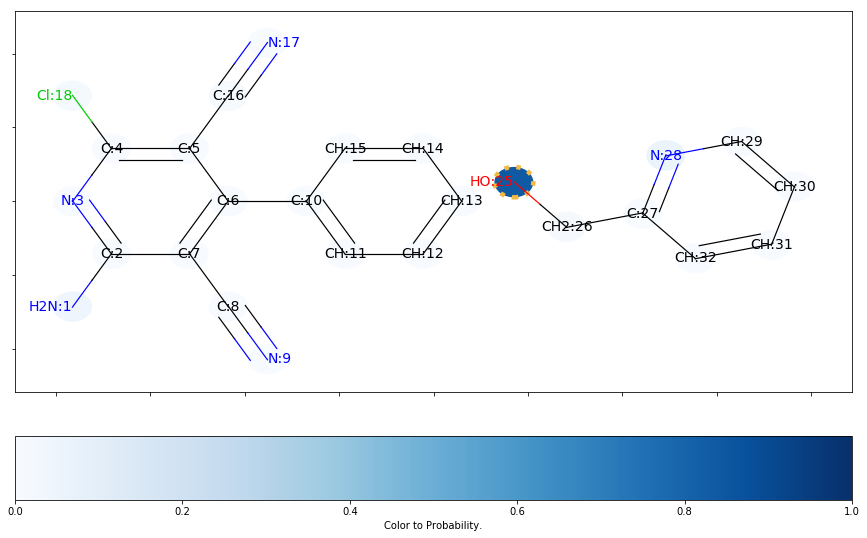

In [15]:
seq_position = 0

mol = rdkit_general_ops.get_molecule('[NH2:1][c:2]1[n:3][c:4]([Cl:18])[c:5]([C:16]#[N:17])[c:6](-[c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[c:7]1[C:8]#[N:9].[OH:25][CH2:26][c:27]1[n:28][cH:29][cH:30][cH:31][cH:32]1')
act_seq = create_action_seq(mol, [25, 25, 4, 18])
mol, probs, disallowed_actions = get_mol_and_action_probs(act_seq, seq_position,
                                                          full_model, cuda_details)

prev_action = None if seq_position == 0 else act_seq.actions_as_am[seq_position-1]
selected_action = act_seq.actions_as_am[seq_position]

fig, ax = plot_actions(mol, probs, disallowed_actions, prev_action, selected_action)
_ = ax[0].plot([],[])  # this line rescales the plot nicely

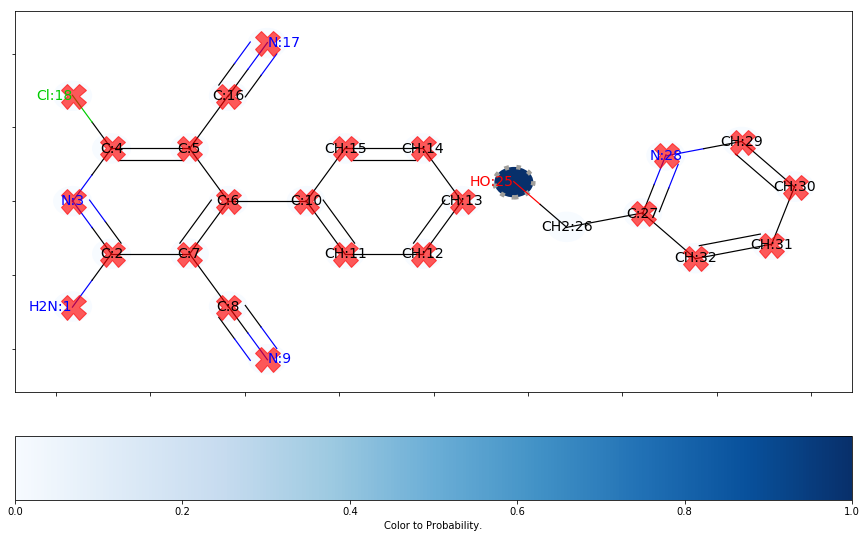

In [16]:
seq_position = 1

mol = rdkit_general_ops.get_molecule('[NH2:1][c:2]1[n:3][c:4]([Cl:18])[c:5]([C:16]#[N:17])[c:6](-[c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[c:7]1[C:8]#[N:9].[OH:25][CH2:26][c:27]1[n:28][cH:29][cH:30][cH:31][cH:32]1')
act_seq = create_action_seq(mol, [25, 25, 4, 18])
mol, probs, disallowed_actions = get_mol_and_action_probs(act_seq, seq_position,
                                                          full_model, cuda_details)

prev_action = None if seq_position == 0 else act_seq.actions_as_am[seq_position-1]
selected_action = act_seq.actions_as_am[seq_position]

fig, ax = plot_actions(mol, probs, disallowed_actions, prev_action, selected_action)

# Note in this example we break a self-bond on the atom with the small grey dotted outline.

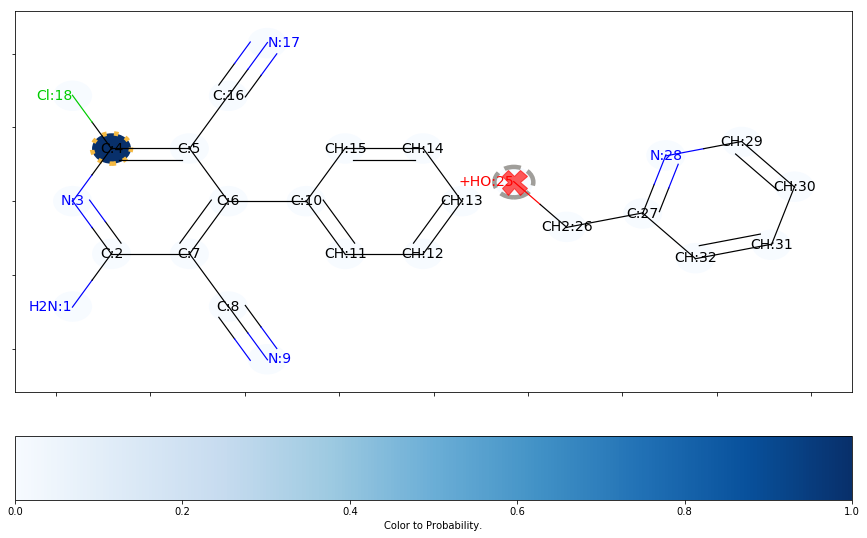

In [17]:
seq_position = 2

mol = rdkit_general_ops.get_molecule('[NH2:1][c:2]1[n:3][c:4]([Cl:18])[c:5]([C:16]#[N:17])[c:6](-[c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[c:7]1[C:8]#[N:9].[OH:25][CH2:26][c:27]1[n:28][cH:29][cH:30][cH:31][cH:32]1')
act_seq = create_action_seq(mol, [25, 25, 4, 18])
mol, probs, disallowed_actions = get_mol_and_action_probs(act_seq, seq_position,
                                                          full_model, cuda_details)

prev_action = None if seq_position == 0 else act_seq.actions_as_am[seq_position-1]
selected_action = act_seq.actions_as_am[seq_position]

fig, ax = plot_actions(mol, probs, disallowed_actions, prev_action, selected_action)

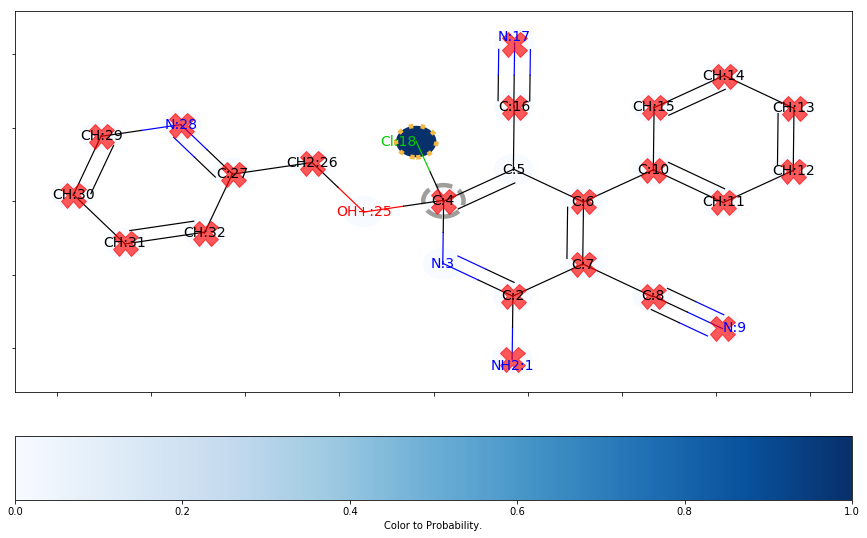

In [18]:
seq_position = 3

mol = rdkit_general_ops.get_molecule('[NH2:1][c:2]1[n:3][c:4]([Cl:18])[c:5]([C:16]#[N:17])[c:6](-[c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[c:7]1[C:8]#[N:9].[OH:25][CH2:26][c:27]1[n:28][cH:29][cH:30][cH:31][cH:32]1')
act_seq = create_action_seq(mol, [25, 25, 4, 18])
mol, probs, disallowed_actions = get_mol_and_action_probs(act_seq, seq_position,
                                                          full_model, cuda_details)

prev_action = None if seq_position == 0 else act_seq.actions_as_am[seq_position-1]
selected_action = act_seq.actions_as_am[seq_position]

fig, ax = plot_actions(mol, probs, disallowed_actions, prev_action, selected_action)
